Make sure to open in Colab to see the plots!

In [2]:
from scipy.integrate import odeint
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

     |████████████████████████████████| 798kB 3.4MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=5e769bc6e610c1f3a094624814b1d8a3508197778cd6cdf7a8c5babb7b93fb48
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


In [0]:
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  if L is not None:
      plt.title("Lockdown after {} days".format(L))
  plt.show();

  if R0 is not None or CFR is not None:
    f = plt.figure(figsize=(12,4))
  
  if R0 is not None:
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  if Alpha is not None:
    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

## Programming the Exposed-Compartment

In [0]:
def deriv(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [0]:
N = 500
D = 10.0 # infections lasts ten days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 3
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
S0, E0, I0, R0 = N-1, 1, 0, 0  # initial conditions: one exposed

In [0]:
t = np.linspace(0, 100, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

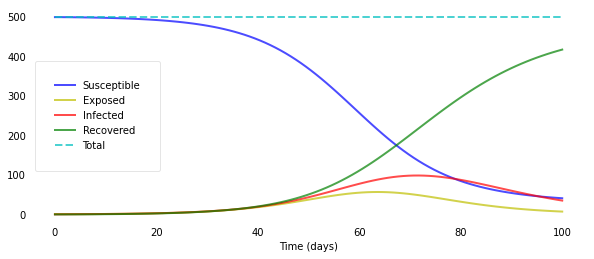

In [7]:
plotseird(t, S, E, I, R)

In [8]:
# get the real data
# fit the curve
data = pd.read_csv('/content/SEIR_data.csv')
data.head()

,Date,S,E,I,R,Incidence
0,13/03/2020,528,0,0,0,0
1,14/03/2020,527,1,0,0,0
2,15/03/2020,527,1,0,0,0
3,16/03/2020,527,1,0,0,0
4,17/03/2020,527,1,0,0,0


In [0]:
def fit_odeint(x, beta, gamma,delta):
    return odeint(deriv, y0, x, args=(N, beta, gamma, delta))[:,2]

In [17]:
x = [i for i in range(0,data.shape[0])]
y = data['I']
dataz = zip(x,y)
# Do the sampling 100 times to get the error estimates 

popt, pcov = optimize.curve_fit(fit_odeint, x, y)
fitted = fit_odeint(x, *popt)
print(*popt)
perr = np.sqrt(np.diag(pcov))
print(pcov)
print(perr)
#print(type(popt))
print("R0 value : %2.4f" %(popt[0]/popt[1]) )

8.557852810598686 2.9590749793307345 0.2804627027948502
[[67.27729487  3.35922824 -2.41622557]
 [ 3.35922824  0.25748755 -0.11055307]
 [-2.41622557 -0.11055307  0.08818979]]
[8.20227376 0.50743231 0.29696765]
<class 'numpy.ndarray'>
R0 value : 2.8921


[ 0.         -0.00621681 -0.00684215 -0.00698588 -0.00708929 -0.00719051
 -0.00729286 -0.00739664 -0.00750189 -0.00760864 -0.00771691 -0.00782672
 -0.0079381  -0.00805105 -0.00816562 -0.00828181 -0.00839967 -0.0085192
 -0.00864041 -0.00876336 -0.00888806 -0.00901454 -0.00914281 -0.00927291
 -0.00940486 -0.00953868 -0.00967442 -0.00981208 -0.0099517  -0.01009331
 -0.01023693 -0.01038259 -0.01053032 -0.01068017 -0.01083214 -0.01098628
 -0.01114261 -0.01130116 -0.01146197 -0.01162506 -0.01179048 -0.01195825
 -0.01212841 -0.01230098 -0.01247602 -0.01265354 -0.01283359 -0.0130162
 -0.01320141 -0.01338925 -0.01357977 -0.013773   -0.01396897 -0.01416774
 -0.01436933 -0.0145738  -0.01478117 -0.01499148 -0.01520479 -0.01542113
 -0.01564057]
[ 0.00000000e+00  3.42399886e-01  1.37325551e+00  5.17680132e+00
  1.58738259e+01  3.00478496e+01  3.15592537e+01  2.30677608e+01
  1.45790318e+01  8.74445680e+00  5.13926761e+00  2.99345411e+00
  1.73595609e+00  1.00440346e+00  5.80409520e-01  3.35164244e-0

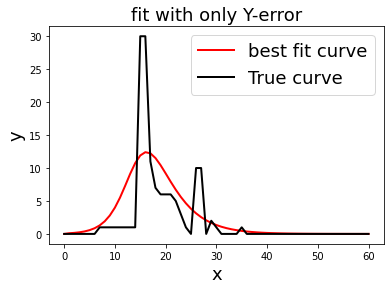

In [13]:
#print(fitted)
#plt.plot(x, y, '-')
#plt.plot(x, fitted, '-')
#plt.show()

# prepare confidence level curves
nstd = 1.0 # to draw 5-sigma intervals
popt_up = popt + nstd*perr
#popt_dw = popt – nstd*perr
popt_dw= popt-nstd*perr
fit = fit_odeint(x, *popt)
fit_up = fit_odeint(x, *popt_up)
fit_dw = fit_odeint(x, *popt_dw)
print(fit_dw)
print(fit_up)
#plot
fig, ax = plt.subplots(1)
#rcParams['xtick.labelsize'] = 18
#rcParams['ytick.labelsize'] = 18
#rcParams['font.size']= 20
#errorbar(x, y0, yerr=noise, xerr=0, hold=True, ecolor=’k’, fmt=’none’, label=’data’)
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_title('fit with only Y-error' , fontsize=18)
plt.plot(x, fit, 'r', lw=2, label='best fit curve')
plt.plot(x, y, 'k-', lw=2, label='True curve')
#plt.plot(x,y,'k-', lw=2)
#ax.fill_between(x,fit_up, fit_dw, alpha = 0.25)
#ax.fill_between(x, fit_up, fit_dw, alpha=.25, label='5-sigma interval')

ax.legend(loc='upper right',fontsize=18)
plt.show()

## Programming the Dead-Compartment

In [0]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [0]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 5.0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [0]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

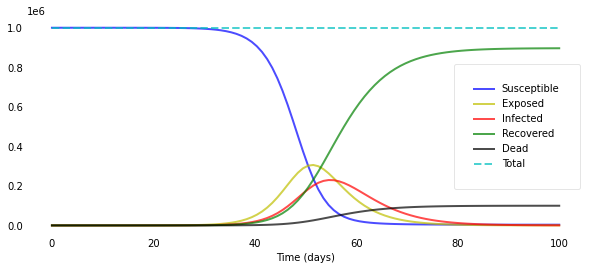

In [0]:
plotseird(t, S, E, I, R, D)

## Time-Dependent $R_{0}$

### Simple Approach: Single Lockdown

In [0]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [0]:
L = 40

In [0]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
def R_0(t):
    return 5.0 if t < L else 0.9
def beta(t):
    return R_0(t) * gamma

alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [0]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

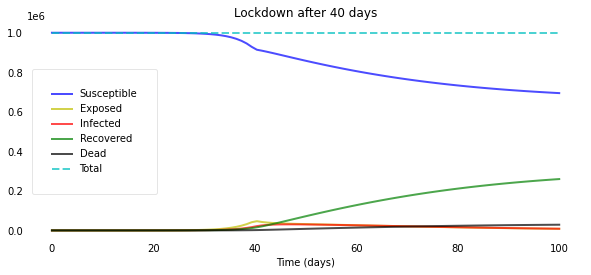

In [0]:
plotseird(t, S, E, I, R, D, L)

### Advanced Approach: logistic $R_{0}$

In [0]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [0]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def beta(t):
    return logistic_R_0(t) * gamma

alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [0]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values

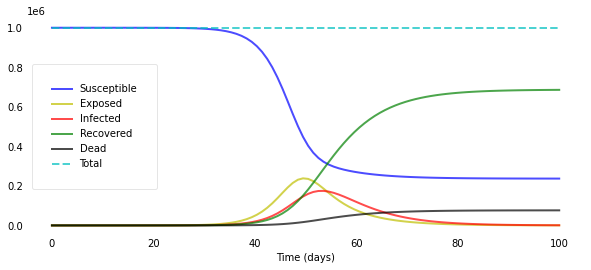

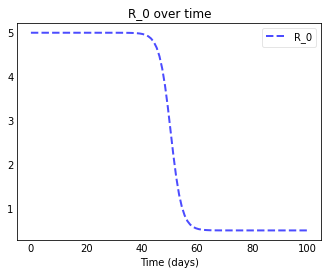

In [0]:
plotseird(t, S, E, I, R, D, R0=R0_over_time)

### Resource- and Age-Dependent Fatality Rate

In [0]:
def deriv(y, t, N, beta, gamma, delta, alpha_opt, rho):
    S, E, I, R, D = y
    def alpha(t):
        return s * I/N + alpha_opt

    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha(t)) * gamma * I - alpha(t) * rho * I
    dRdt = (1 - alpha(t)) * gamma * I
    dDdt = alpha(t) * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [0]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def beta(t):
    return logistic_R_0(t) * gamma

alpha_by_agegroup = {"0-29": 0.01, "30-59": 0.05, "60-89": 0.2, "89+": 0.3}
proportion_of_agegroup = {"0-29": 0.1, "30-59": 0.3, "60-89": 0.4, "89+": 0.2}
s = 0.01
alpha_opt = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))

rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [0]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha_opt, rho))
S, E, I, R, D = ret.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values
Alpha_over_time = [s * I[i]/N + alpha_opt for i in range(len(t))]  # to plot alpha over time

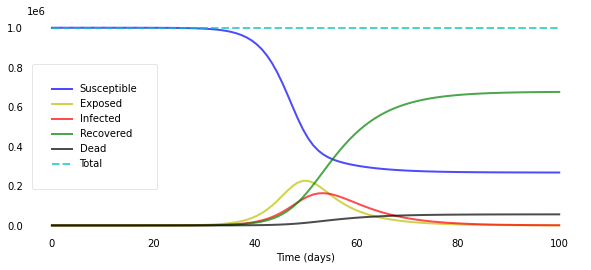

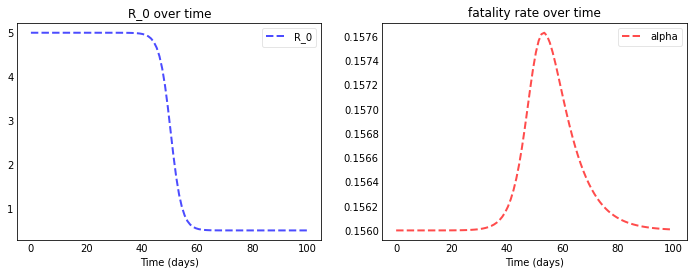

In [0]:
plotseird(t, S, E, I, R, D, R0=R0_over_time, Alpha=Alpha_over_time)